In [30]:
import pandas as pd

import numpy as np
import itertools
import category_encoders as ce

from numpy import mean
from numpy import std
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [31]:
pip install pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.metrics import precision_score, recall_score, auc
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import shapiro, normaltest
import category_encoders as ce
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [33]:
#df = pd.read_csv('bank updated.csv')              Old .csv with numeric pdays.

df = pd.read_csv('bank updated categories.csv')

col_names = ['age', 
             'job', 
             'martial', 
             'education', 
             'cred_in_default', 
             'balance',
             'housing',
             'loan',
             'contact',
             'last_contact_day',
             'last_contact_month',
             'last_contact_dur',
             'num_of_contacts_during_campaign',
             'past_days',
             'prev_contacts',
             'prev_outcome',
             'sub_term_deposit']
df.columns = col_names
df.head()

,age,job,martial,education,cred_in_default,balance,housing,loan,contact,last_contact_day,last_contact_month,last_contact_dur,num_of_contacts_during_campaign,past_days,prev_contacts,prev_outcome,sub_term_deposit
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,No Contact,0,unknown,no
1,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,No Contact,0,unknown,no
2,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,No Contact,0,unknown,no
3,39,technician,married,secondary,no,147,yes,no,cellular,6,may,151,2,No Contact,0,unknown,no
4,41,entrepreneur,married,tertiary,no,221,yes,no,unknown,14,may,57,2,No Contact,0,unknown,no


In [34]:
##Prep for MLP
print("Bank data set dimensions : {}".format(df.shape))

Bank data set dimensions : (4521, 17)


In [35]:
from sklearn.preprocessing import OrdinalEncoder

# Load the dataset
df = pd.read_csv('bank updated categories.csv')

# Define features and target
X = df[['age', 'job', 'marital', 'education', 'balance', 'housing',
        'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
        'previous', 'poutcome']]
y = df['y'] 

# Define the columns to encode
cols_to_encode = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'pdays', 'poutcome']

# Filter cols_to_encode to include only those present in X
cols_to_encode = [col for col in cols_to_encode if col in X.columns]

# Extract column indices for encoding
col_indices = [X.columns.get_loc(col) for col in cols_to_encode]

# Create the encoder
encoder = OrdinalEncoder()
X_enc = X.copy()  # Make a copy of X
X_enc[cols_to_encode] = encoder.fit_transform(X[cols_to_encode])

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.3, stratify=y, random_state=3)


print("y_test set dimensions : {}".format(y_test.shape))

# Define the MLPClassifier
mlp = MLPClassifier(
    max_iter=200,
    alpha=0.1,
    activation='logistic',
    solver='adam')

# Fit the model to the training data
mlp.fit(X_enc, y)
mlp_predict = mlp.predict(X_enc)

y_test set dimensions : (1357,)


In [36]:
###Part B question B 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define a range of number of neurons (k) and number of iterations
neurons_range = range(1, 26)  # From 1 to 25 neurons
iterations_range = [100, 200, 300, 400, 500] # Specify a range of iterations to test

# Define parameters for the grid search
param_grid = {'hidden_layer_sizes': [(k,) for k in neurons_range],  # Single hidden layer with k neurons
              'max_iter': iterations_range}  # Varying number of iterations

# Create an MLPClassifier instance
mlp = MLPClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Get the best iteration for the best parameters
best_iter = grid_search.cv_results_['param_max_iter'][grid_search.best_index_]

# Predict on the test set using the best parameters
y_pred = grid_search.best_estimator_.predict(X_test)

# Generate and print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Best parameters:", best_params)
print("Best accuracy: {:.2f}%".format(best_accuracy * 100))
print("Best iteration:", best_iter)

Classification Report:
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      1201
         yes       0.00      0.00      0.00       156

    accuracy                           0.89      1357
   macro avg       0.44      0.50      0.47      1357
weighted avg       0.78      0.89      0.83      1357

Best parameters: {'hidden_layer_sizes': (3,), 'max_iter': 300}
Best accuracy: 88.72%
Best iteration: 300


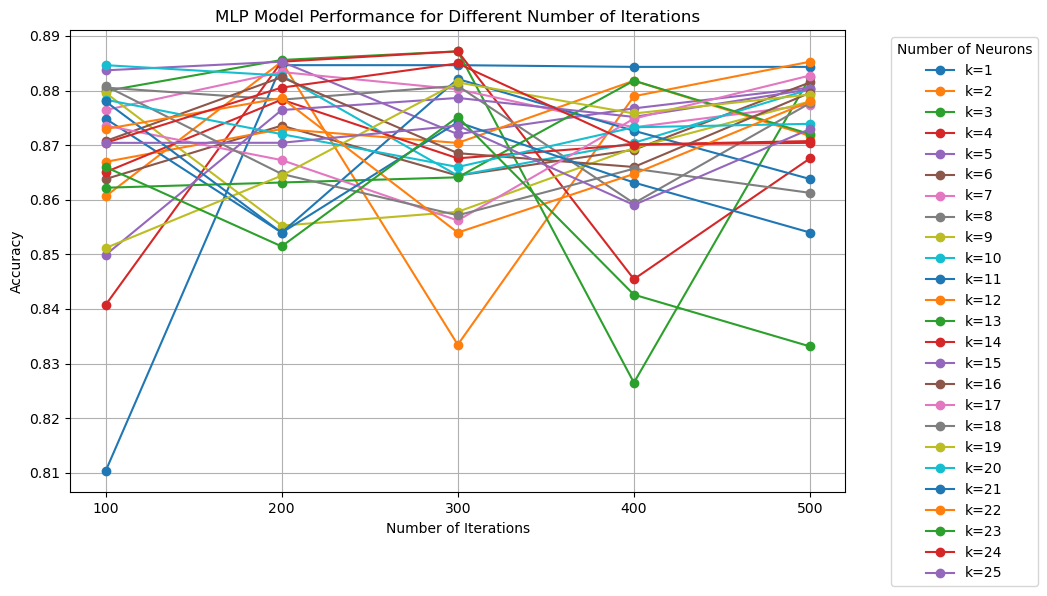

In [37]:
####Part B question B -  Plotting the accuracy for each number of iterations
results = grid_search.cv_results_
mean_test_scores = np.array([results['mean_test_score'][i::len(iterations_range)] for i in range(len(iterations_range))])

plt.figure(figsize=(10, 6))
for i, k in enumerate(neurons_range):
    plt.plot(iterations_range, mean_test_scores[:, i], marker='o', label=f'k={k}')

plt.title('MLP Model Performance for Different Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.xticks(iterations_range)
plt.legend(title='Number of Neurons', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Iteration 1, loss = 4.37145807
Iteration 2, loss = 3.40486362
Iteration 3, loss = 1.75432514
Iteration 4, loss = 0.85568259
Iteration 5, loss = 0.74435357
Iteration 6, loss = 0.58966807
Iteration 7, loss = 0.47686577
Iteration 8, loss = 0.61353118
Iteration 9, loss = 0.57665041
Iteration 10, loss = 0.51098785
Iteration 11, loss = 0.45062130
Iteration 12, loss = 1.08631374
Iteration 13, loss = 1.10782261
Iteration 14, loss = 0.64265797
Iteration 15, loss = 0.77819257
Iteration 16, loss = 0.67551907
Iteration 17, loss = 0.52727932
Iteration 18, loss = 0.41799468
Iteration 19, loss = 0.37965821
Iteration 20, loss = 0.41835326
Iteration 21, loss = 0.52746054
Iteration 22, loss = 0.66197003
Iteration 23, loss = 0.65320831
Iteration 24, loss = 0.70823095
Iteration 25, loss = 0.59334714
Iteration 26, loss = 0.58971559
Iteration 27, loss = 0.43370348
Iteration 28, loss = 0.59212066
Iteration 29, loss = 0.36230199
Iteration 30, loss = 0.44679986
Iteration 31, loss = 0.58851047
Iteration 32, los

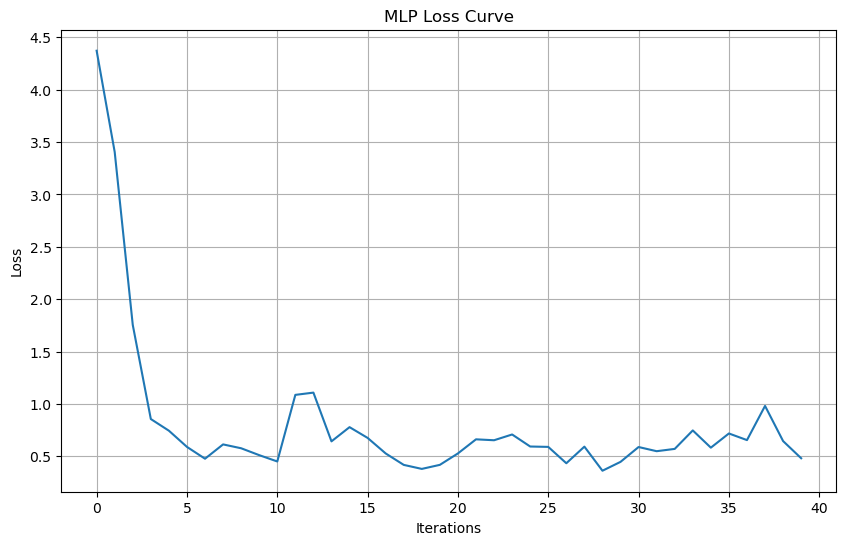

In [39]:
##Question C Part B
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Create an MLPClassifier instance with default parameter values and verbose set to True
mlp = MLPClassifier(verbose=True)

# Fit the model to the training data
mlp.fit(X_train, y_train)

# Predict using the testing set
mlp_predict = mlp.predict(X_test)

# Calculate MLP Accuracy
mlp_accuracy = accuracy_score(y_test, mlp_predict)

# MLP Classification report
mlp_classification_report = classification_report(y_test, mlp_predict)

# MLP Training set score
mlp_training_score = mlp.score(X_train, y_train)

# MLP Testing set score
mlp_testing_score = mlp.score(X_test, y_test)

# Print MLP Accuracy, Classification report, Training set score, and Testing set score as percentages
#print("MLP Accuracy: {:.2f}%".format(mlp_accuracy * 100))
#print("\nMLP Classification Report:\n", mlp_classification_report)
#print("\nMLP Training set score: {:.2f}%".format(mlp_training_score * 100))
#print("MLP Testing set score: {:.2f}%".format(mlp_testing_score * 100))

# Plotting the loss curve
loss_values = mlp.loss_curve_
plt.figure(figsize=(10, 6))
plt.plot(loss_values)
plt.title('MLP Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [40]:
##Question d Part B
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define a range of number of neurons (k)
neurons = 25  # Total number of neurons to be split between two layers
iterations_range = [100, 200, 300, 400, 500]  # Specify a range of iterations to test

# Generate combinations of neurons for two hidden layers
hidden_layer_sizes = [(k, neurons - k) for k in range(1, neurons)]

# Define parameters for the grid search
param_grid = {'hidden_layer_sizes': hidden_layer_sizes,  # Two hidden layers with varying neurons
              'max_iter': iterations_range}  # Varying number of iterations

# Create an MLPClassifier instance
mlp = MLPClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Get the best iteration for the best parameters
best_iter = grid_search.cv_results_['param_max_iter'][grid_search.best_index_]

# Predict on the test set using the best parameters
y_pred = grid_search.best_estimator_.predict(X_test)

# Generate and print the classification report
#print("Classification Report:")
#print(classification_report(y_test, y_pred))

#print("Best parameters:", best_params)
#print("Best accuracy: {:.2f}%".format(best_accuracy * 100))
#print("Best iteration:", best_iter)

In [41]:
#Question d part b continued.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from collections import defaultdict

# Define a range of number of neurons (k)
neurons = 25  # Total number of neurons to be split between two layers
iterations_range = [100, 200, 300, 400, 500]  # Specify a range of iterations to test

# Generate combinations of neurons for two hidden layers
hidden_layer_sizes = [(k, neurons - k) for k in range(1, neurons)]

# Define parameters for the grid search
param_grid = {'hidden_layer_sizes': hidden_layer_sizes,  # Two hidden layers with varying neurons
              'max_iter': iterations_range}  # Varying number of iterations

# Create an MLPClassifier instance
mlp = MLPClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Get the best iteration for the best parameters
best_iter = grid_search.cv_results_['param_max_iter'][grid_search.best_index_]

# Predict on the test set using the best parameters
y_pred = grid_search.best_estimator_.predict(X_test)

# Generate and print the classification report
#print("Classification Report:")
#print(classification_report(y_test, y_pred))

#print("Best parameters:", best_params)
#print("Best accuracy: {:.2f}%".format(best_accuracy * 100))
#print("Best iteration:", best_iter)

results = grid_search.cv_results_

# Initialize the dictionary to hold accuracies
accuracy_dict = defaultdict(list)

# Iterate over the results and populate the dictionary
for i in range(len(results['params'])):
    combination = results['params'][i]['hidden_layer_sizes']
    accuracy = results['mean_test_score'][i]
    accuracy_dict[combination].append(accuracy)

# Compute the mean accuracy for each combination
mean_accuracies = {k: sum(v) / len(v) for k, v in accuracy_dict.items()}

# Prepare the results table
results_table = [(k, v) for k, v in mean_accuracies.items()]

# Sort the results table by accuracy in descending order for better readability
results_table.sort(key=lambda x: x[1], reverse=True)

# Print the results table
print("\nResults Table in Order of Accuracy:")
print("{:<15} {:<10}".format('Combination', 'Accuracy'))
for row in results_table:
    print("{:<15} {:.2f}%".format(str(row[0]), row[1] * 100))


Results Table in Order of Accuracy:
Combination     Accuracy  
(22, 3)         88.40%
(1, 24)         88.31%
(4, 21)         88.19%
(3, 22)         87.95%
(15, 10)        87.93%
(5, 20)         87.90%
(6, 19)         87.90%
(8, 17)         87.86%
(20, 5)         87.78%
(7, 18)         87.67%
(9, 16)         87.53%
(19, 6)         87.52%
(21, 4)         87.49%
(2, 23)         87.41%
(10, 15)        87.25%
(18, 7)         86.86%
(13, 12)        86.78%
(17, 8)         86.74%
(12, 13)        86.74%
(16, 9)         86.69%
(11, 14)        86.59%
(14, 11)        86.21%
(24, 1)         85.30%
(23, 2)         85.25%


In [42]:
# Sort the results table by the first element of the combination (i.e., the number of neurons in the first hidden layer)
results_table.sort(key=lambda x: x[0][0])
# Print the results table
print("Results Table in Order of Combination:")
print("{:<15} {:<10}".format('Combination', 'Accuracy'))
for row in results_table:
    print("{:<15} {:.2f}%".format(str(row[0]), row[1] * 100))

Results Table in Order of Combination:
Combination     Accuracy  
(1, 24)         88.31%
(2, 23)         87.41%
(3, 22)         87.95%
(4, 21)         88.19%
(5, 20)         87.90%
(6, 19)         87.90%
(7, 18)         87.67%
(8, 17)         87.86%
(9, 16)         87.53%
(10, 15)        87.25%
(11, 14)        86.59%
(12, 13)        86.74%
(13, 12)        86.78%
(14, 11)        86.21%
(15, 10)        87.93%
(16, 9)         86.69%
(17, 8)         86.74%
(18, 7)         86.86%
(19, 6)         87.52%
(20, 5)         87.78%
(21, 4)         87.49%
(22, 3)         88.40%
(23, 2)         85.25%
(24, 1)         85.30%
